# 1 - Source Text Filtering

In [1]:
import sys
print(sys.version)

3.5.2 |Continuum Analytics, Inc.| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


In [2]:
# Use AzureML's data collector to log various metrics!
#from azureml.logging import current_scriptrun
#logger = current_scriptrun()

import string, re
import pandas as pd
from nltk.corpus import stopwords
from gensim import corpora, models, similarities
import azureml
from __future__ import division
import numpy as np
import nltk
from nltk.corpus import stopwords
from azure.storage.blob import BlockBlobService

C:\Users\pattyry\AppData\local\AmlWorkbench\Python\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Import source text and write to a pandas dataframe

In [3]:
import os
os.getcwd()

'C:\\Users\\pattyry\\Documents\\AzureML\\NextAgenda_CodeStory\\NextAgenda_CodeStory'

In [4]:
import pickle
with open('Data2.pkl', 'rb') as f:
    data = pickle.load(f)
    print("Data unpickled")
    import pandas as pd
data = pd.DataFrame(data)
data.shape

Data unpickled


(32233, 16)

Review data

In [5]:
data.head(2)

,Ticker,Year,Month,Day,Date,Category,Category Number,Future_4_weeks,Future_26_weeks,Text,Label,Price_Date,Price_4_weeks,Price_26_weeks,Return_4_weeks,Return_26_weeks
1,AAL,2014,02,28,2014-02-28,Major Airlines,770,2014-03-28,2014-08-29,OverviewAmerican Airlines Group Inc. (AAG) a D...,Item1,35.798592,34.305775,37.784386,-4.178315,0.788191
2,AAL,2013,02,20,2013-02-20,Major Airlines,770,2013-03-20,2013-08-21,"Chapter 11 ProceedingsOn November 29, 2011 (th...",Item1,12.921616,16.702129,15.325636,25.062782,11.639949


In [6]:
data['Year'].value_counts()

2014    4174
2015    4033
2012    3694
2013    3652
2016    3594
2011    2901
2010    2774
2009    2675
2017    2451
2008    2285
Name: Year, dtype: int64

Discard some data, Append Ticker to the text.

In [7]:
data1=data.drop(['Month', 'Day','Year'], axis=1)
data1['fulltext'] = data1[['Ticker', 'Text']].apply(lambda x: '.   '.join(x), axis=1)
print(data1.shape)
data1.head(2)

(32233, 14)


,Ticker,Date,Category,Category Number,Future_4_weeks,Future_26_weeks,Text,Label,Price_Date,Price_4_weeks,Price_26_weeks,Return_4_weeks,Return_26_weeks,fulltext
1,AAL,2014-02-28,Major Airlines,770,2014-03-28,2014-08-29,OverviewAmerican Airlines Group Inc. (AAG) a D...,Item1,35.798592,34.305775,37.784386,-4.178315,0.788191,AAL. OverviewAmerican Airlines Group Inc. (A...
2,AAL,2013-02-20,Major Airlines,770,2013-03-20,2013-08-21,"Chapter 11 ProceedingsOn November 29, 2011 (th...",Item1,12.921616,16.702129,15.325636,25.062782,11.639949,"AAL. Chapter 11 ProceedingsOn November 29, 2..."


Create calculated normalized percent return, creaate TWO bins

(32233, 18)


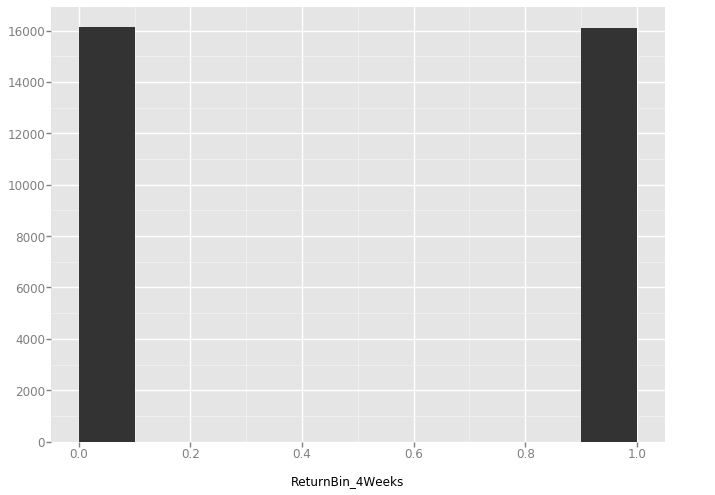

<ggplot: (101638655152)>

In [9]:
data2=data1
data2["PercReturn_4_Weeks"] = data2.Return_4_weeks / data2.Price_Date
data2["PercReturn_26_Weeks"] = data2.Return_26_weeks / data2.Price_Date
data2["ReturnBin_4Weeks"] = pd.qcut(data2["PercReturn_4_Weeks"], 2,labels=range(2))
data2["ReturnBin_26Weeks"] = pd.qcut(data2["PercReturn_26_Weeks"], 2,labels=range(2))
referencedata=data2
print(data2.shape)
data2.head(2)
import ggplot
from ggplot import *
ggplot(data2, aes(x='ReturnBin_4Weeks')) + \
    geom_histogram() 

In [10]:
df=data2
df['fulltext'] = df[['Ticker', 'Text']].apply(lambda x: '.   '.join(x), axis=1)
df=df.drop(['Text','Ticker','Category Number','Label'], axis=1)
print(df.shape)

(32233, 14)


In [11]:
allindustrydata=df
allindustrydata=allindustrydata.drop(['PercReturn_4_Weeks',
                                      'Future_4_weeks','Future_26_weeks','Date','Price_4_weeks','Price_26_weeks','Price_Date','PercReturn_26_Weeks','Return_4_weeks','Return_26_weeks'], axis=1)
print(allindustrydata.Category.unique())
allindustrydata.head(2)

['Major Airlines' 'Rental & Leasing Services' 'General Building Materials'
 'Electronic Equipment' 'Auto Parts Stores' 'Air Services'
 'Regional - Mid-Atlantic Banks' 'Drugs Wholesale' 'Auto Dealerships'
 'Medical Appliances & Equipment' 'REIT - Diversified' 'Biotechnology'
 'Office Supplies' 'REIT - Residential' 'Property & Casualty Insurance'
 'Technical & System Software' 'Semiconductor Equipment & Materials'
 'Technical Services' 'Information Technology Services'
 'Application Software' 'Business Services' 'Housewares & Accessories'
 'Property Management' 'Semiconductor - Integrated Circuits'
 'Long-Term Care Facilities' 'Farm Products' 'Business Software & Services'
 'Electric Utilities' 'Diversified Electronics' 'Life Insurance'
 'Apparel Stores' 'Health Care Plans' 'Home Health Care' ''
 'Farm & Construction Machinery' 'Credit Services' 'Drugs - Generic'
 'REIT - Hotel/Motel' 'Aerospace/Defense Products & Services'
 'Accident & Health Insurance' 'Mortgage Investment' 'Insurance 

,Category,fulltext,ReturnBin_4Weeks,ReturnBin_26Weeks
1,Major Airlines,AAL. OverviewAmerican Airlines Group Inc. (A...,0,0
2,Major Airlines,"AAL. Chapter 11 ProceedingsOn November 29, 2...",1,1


In [18]:
with open('allindustriessource2bin.pkl', 'wb') as f:
    pickle.dump(allindustrydata, f)
#df = pd.read_pickle(file_name)

In [19]:
df1 = df[(df['Category'] =="Biotechnology")]
print(df1['Category'].value_counts())
df1.shape
df1.head(2)

Biotechnology    996
Name: Category, dtype: int64


,Date,Category,Future_4_weeks,Future_26_weeks,Price_Date,Price_4_weeks,Price_26_weeks,Return_4_weeks,Return_26_weeks,fulltext,PercReturn_4_Weeks,PercReturn_26_Weeks,ReturnBin_4Weeks,ReturnBin_26Weeks
131,2008-03-05,Biotechnology,2008-04-02,2008-09-03,9.30,8.990000,2.690000,-6.196167,-65.182894,ACAD. . Overview We are a biopharmaceutical ...,-0.666255,-7.008913,0,0
133,2016-02-29,Biotechnology,2016-03-28,2016-08-29,17.26,23.809999,32.619999,31.780087,76.964577,ACAD. . Company Overview We are a biopharmac...,1.841257,4.459130,1,1


C:\Users\pattyry\AppData\local\AmlWorkbench\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pattyry\AppData\local\AmlWorkbench\Python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pattyry\AppData\local\AmlWorkbench\Python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

(996, 14)


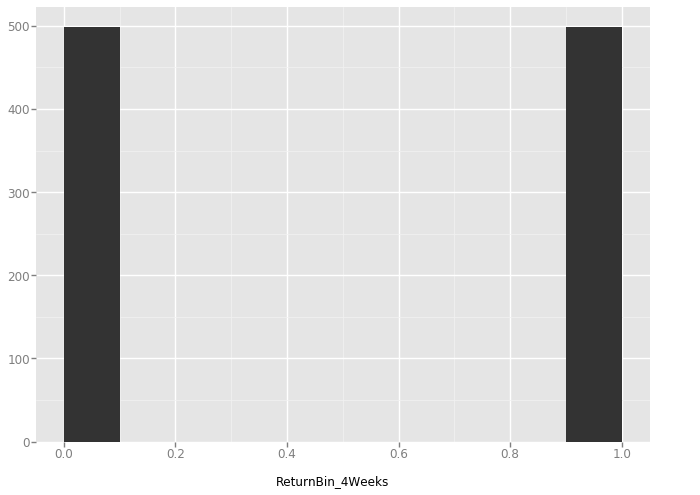

<ggplot: (-9223371935505209179)>

In [20]:
data2=df1
data2["PercReturn_4_Weeks"] = data2.Return_4_weeks / data2.Price_Date
data2["PercReturn_26_Weeks"] = data2.Return_26_weeks / data2.Price_Date
data2["ReturnBin_4Weeks"] = pd.qcut(data2["PercReturn_4_Weeks"], 2,labels=range(2))
data2["ReturnBin_26Weeks"] = pd.qcut(data2["PercReturn_26_Weeks"], 2,labels=range(2))
referencedata=data2
print(data2.shape)
data2.head(2)
import ggplot
from ggplot import *
ggplot(data2, aes(x='ReturnBin_4Weeks')) + \
    geom_histogram() 

In [21]:
data2=data2.drop(['PercReturn_4_Weeks','Category',
                    'Future_4_weeks','Future_26_weeks','Date','Price_4_weeks','Price_26_weeks',
                    'Price_Date','PercReturn_26_Weeks','Return_4_weeks','Return_26_weeks'], axis=1)

print(data2.shape)
data2.head(2)

(996, 3)


,fulltext,ReturnBin_4Weeks,ReturnBin_26Weeks
131,ACAD. . Overview We are a biopharmaceutical ...,0,0
133,ACAD. . Company Overview We are a biopharmac...,1,1


In [22]:
with open('biotechsource2bin.pkl', 'wb') as f:
    pickle.dump(data2, f)
#df = pd.read_pickle(file_name)